# Import Packages

In [1]:
import os
import xlsxwriter
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import itertools
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import statsmodels.api as sm 
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.compat import lzip
import warnings
os.listdir()

['.ipynb_checkpoints',
 'basisdata waterverbruik.xlsx',
 'Linear Regression Model.ipynb',
 'Paper',
 'Preliminary Analysis.ipynb',
 'README.txt',
 'requirements.txt',
 'Scikit Model Comparison.ipynb',
 'Thesis.rar']

# Load Data from Excet Sheet

In [2]:

path = ("basisdata waterverbruik.xlsx")

xl = pd.ExcelFile(path)

print(xl.sheet_names)

['reinwater SAP']


# Parse dataframe and cleaning up weekend/year fraction variables

In [3]:
warnings.filterwarnings("ignore")
df = xl.parse("reinwater SAP")

#year starts at day 1
daycount = 1;
#max day variable
year = 365
df['summer-vac'] = np.nan
df['gelder'] = 0
df['flevo'] = 0
df['utrecht'] = 0
df['fries'] = 0
df['over'] = 0
province = df['provnaam'].iloc[0]
for index, row in df.iterrows():
    #check if its a leap year, then set max day to 366
    if(row['jaar'] % 4 == 0):
        year = 366
    else:
        year = 365
    #reset days if the data switches to the next province
    if(daycount > year):
        daycount = 1
    if(province != row['provnaam']):
        daycount = 1
    
    df.set_value(index,'jaarfractie',daycount/year)
    #only weekends should be set to 1
    if(row['dag'] != 1 and row['dag'] != 7):
        df.set_value(index,'weekend',0)
        df.set_value(index,'doordeweek',1)
    
    province = row['provnaam']
    daycount = daycount + 1
    
    #assign correct summer vacation indicators and dummy encode provinces
    if row['provnaam'] == 'Flevoland' or row['provnaam'] == 'Friesland' or row['provnaam'] == 'Overijssel':
        df.set_value(index,'summer-vac',row['zomer-vakantie noord.1'])
        if row['provnaam'] == 'Flevoland':
            df.set_value(index,'flevo',1)
        if row['provnaam'] == 'Friesland':
            df.set_value(index,'fries',1)
        else:
            df.set_value(index,'over',1)
    if row['provnaam'] == 'Utrecht':
        df.set_value(index,'utrecht',1)
        df.set_value(index,'summer-vac',row['zomer-vakantie midden.1'])
    else:
        df.set_value(index,'gelder',1)
        df.set_value(index,'summer-vac',row['zomer-vakantie zuid.1'])
    
    

# Setup Data for Linear Model and other methods for model

In [4]:

def create_frame(province):
    
    df1 = df
    #select provinces for the model
    if(province != "all"):
        df1 = df.loc[df['provnaam'] == province] 
    #select independent vars
    x = df1[['jaarfractie','bevolking','summer-vac','tem>20','verd De Bilt','zaagtand','weekdag1','weekdag2','weekdag3','weekdag4','weekdag5','weekdag6']]
    #dependent var
    y = df1['tot verbruik'].values.reshape(-1,1)
    x = sm.add_constant(x)
    
    return(x,y)


def make_plot(mod,X_test,y_test):
    
    fig=plt.figure(figsize=(15, 10))
    fig.suptitle('Predicted vs Actual', fontsize=14, fontweight='bold')
    plt.xlabel('Actual',fontsize=16)
    plt.ylabel('Predicted',fontsize=16)

    y1 = mod.predict(X_test)

    plt.scatter(y_test,y1)
    return fig

#use this function to create the model, "all" for use of data from all provinces otherwise type the name of the province
#pop_flag should remain false if you would like 
def create_model(province,pop_flag):
    
    x, y = create_frame(province)
    
    if(pop_flag == True):
        x = x.drop(['bevolking'],axis=1)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=40)

    mod = sm.OLS(y_train,X_train.astype(float)).fit()
    fig = make_plot(mod,X_test,y_test)
    return mod, fig, x, y_train, mod.mse_model
    

# Linear Regression Model Across All Regions With Population Included
The model predicts the distinct groups found in the data, but within each group the prediction is some what accurate at best. The high r^2 score can be attributed to the model predicting the groups accurately.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 2.600e+04
Date:                Thu, 01 Aug 2019   Prob (F-statistic):               0.00
Time:                        12:48:28   Log-Likelihood:                -87495.
No. Observations:                7899   AIC:                         1.750e+05
Df Residuals:                    7886   BIC:                         1.751e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          792.2129    710.198      1.115      0.265    -599.964    2184.390
jaarfractie   2429.2621    757.428      3.207      0.001     944.502    3914.022
bevolking        0.1729      0.000    556.815      0.000       0.172       0.174
summer-vac   -5486.4188    717.036     -7.652      0.000   -6892.000   -4080.838
tem>20        3796.7022     89.016     42.652      0.000    3622.207    3971.197
verd De Bilt   697.7295     91.926      7.590      0.000     517.531     877.928
zaagtand      1.635e+04    971.523     16.831      0.000    1.44e+04    1.83e+04
weekdag1     -5964.7025    659.197     -9.048      0.000   -7256.903   -4672.502
weekdag2     -2025.6728    659.883     -3.070      0.002   -3319.218    -732.128
weekdag3     -2265.5803    666.463     -3.399      0.001   -3572.024    -959.136
weekdag4     -1206.9618    662.039     -1.823      0.068   -2504.734      90.811
weekdag5     -3313.5703    663.024     -4.998      0.000   -4613.273   -2013.867
weekdag6     -3129.5217    660.220     -4.740      0.000   -4423.728   -1835.315
==============================================================================
Omnibus:                      938.233   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4519.489
Skew:                           0.484   Prob(JB):                         0.00
Kurtosis:                       6.577   Cond. No.                     9.55e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.55e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

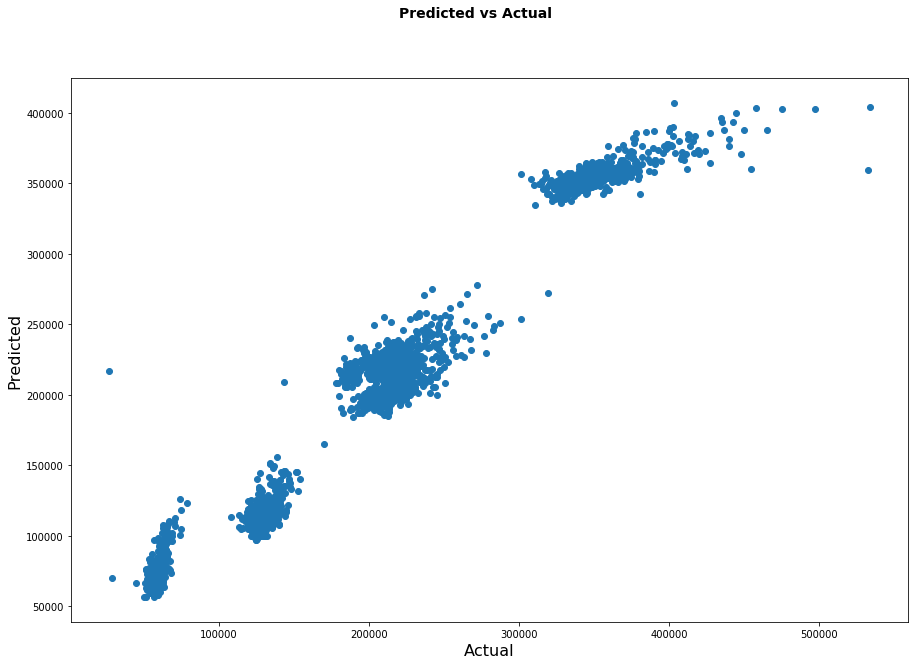

In [5]:
mod, fig, x, y_train, mse = create_model("all",False)
mod.summary()

# Linear Regression Model Across All Regions without Population
Without population the model does a very poor job at predicting water consumption. This makes sense since most other variables remain the same. In other words, for any given day and temperature, all 5 provinces will share the exact same data.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     4.468
Date:                Thu, 01 Aug 2019   Prob (F-statistic):           9.37e-07
Time:                        12:48:28   Log-Likelihood:            -1.0210e+05
No. Observations:                7899   AIC:                         2.042e+05
Df Residuals:                    7887   BIC:                         2.043e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.926e+05   3943.455     48.829      0.000    1.85e+05       2e+05
jaarfractie  -1625.2995   4808.729     -0.338      0.735   -1.11e+04    7801.083
summer-vac   -7395.1226   4552.449     -1.624      0.104   -1.63e+04    1528.883
tem>20        3425.8880    565.151      6.062      0.000    2318.043    4533.733
verd De Bilt   533.3304    583.637      0.914      0.361    -610.753    1677.414
zaagtand      1.084e+04   6167.930      1.757      0.079   -1253.529    2.29e+04
weekdag1     -3278.0092   4185.164     -0.783      0.434   -1.15e+04    4926.020
weekdag2      -532.0223   4189.596     -0.127      0.899   -8744.740    7680.696
weekdag3     -1324.8899   4231.395     -0.313      0.754   -9619.545    6969.765
weekdag4       657.9406   4203.268      0.157      0.876   -7581.579    8897.460
weekdag5     -5290.1536   4209.516     -1.257      0.209   -1.35e+04    2961.612
weekdag6     -2212.5537   4191.759     -0.528      0.598   -1.04e+04    6004.404
==============================================================================
Omnibus:                      857.688   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              337.550
Skew:                           0.294   Prob(JB):                     5.03e-74
Kurtosis:                       2.176   Cond. No.                         22.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

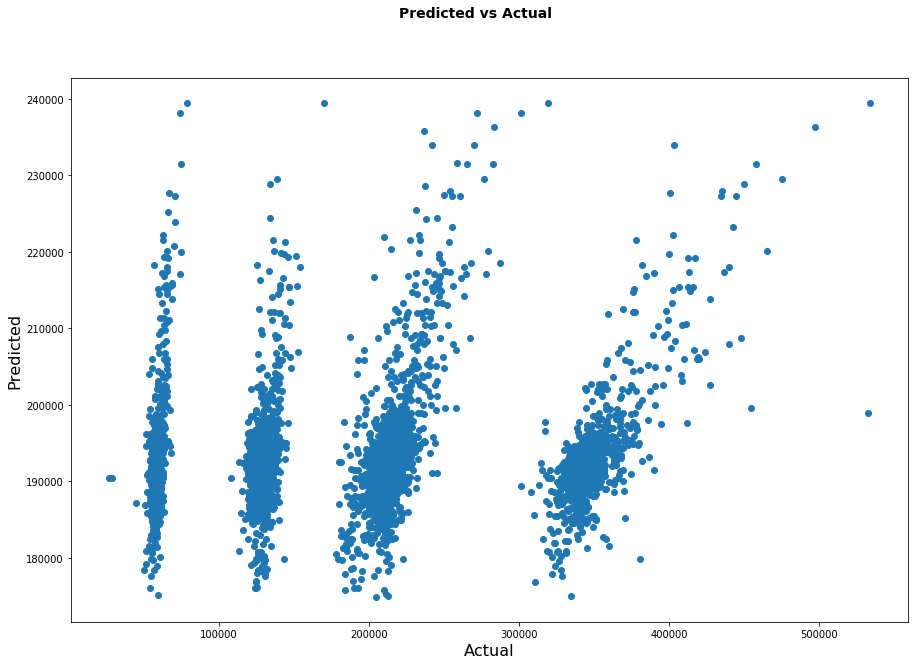

In [6]:
mod, fig, x, y_train, mse = create_model("all",True)
mod.summary()

# Linear Regression Model On Gelderland Region
When only running regression on one region of the model, the r^2 score goes down because the linear model is not as accurate when predicting particular days over one region as it is predicting the overall water consumption of a region compared to others.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     255.6
Date:                Thu, 01 Aug 2019   Prob (F-statistic):               0.00
Time:                        12:48:28   Log-Likelihood:                -17348.
No. Observations:                1579   AIC:                         3.472e+04
Df Residuals:                    1566   BIC:                         3.479e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -9.812e+04   4.55e+04     -2.158      0.031   -1.87e+05   -8918.395
jaarfractie   3897.6349   1572.221      2.479      0.013     813.754    6981.516
bevolking        0.2196      0.022      9.809      0.000       0.176       0.264
summer-vac   -9248.0694   1482.140     -6.240      0.000   -1.22e+04   -6340.882
tem>20        8538.4919    179.358     47.606      0.000    8186.685    8890.299
verd De Bilt  1247.3738    189.891      6.569      0.000     874.907    1619.841
zaagtand      3.101e+04   2041.031     15.194      0.000     2.7e+04     3.5e+04
weekdag1     -1.687e+04   1374.568    -12.276      0.000   -1.96e+04   -1.42e+04
weekdag2     -4418.0641   1355.964     -3.258      0.001   -7077.760   -1758.368
weekdag3     -9123.0231   1350.106     -6.757      0.000   -1.18e+04   -6474.816
weekdag4     -3658.8538   1356.241     -2.698      0.007   -6319.093    -998.615
weekdag5     -1.148e+04   1368.506     -8.390      0.000   -1.42e+04   -8797.679
weekdag6     -8223.2187   1335.636     -6.157      0.000   -1.08e+04   -5603.396
==============================================================================
Omnibus:                      321.339   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7834.652
Skew:                           0.284   Prob(JB):                         0.00
Kurtosis:                      13.898   Cond. No.                     2.56e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.56e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

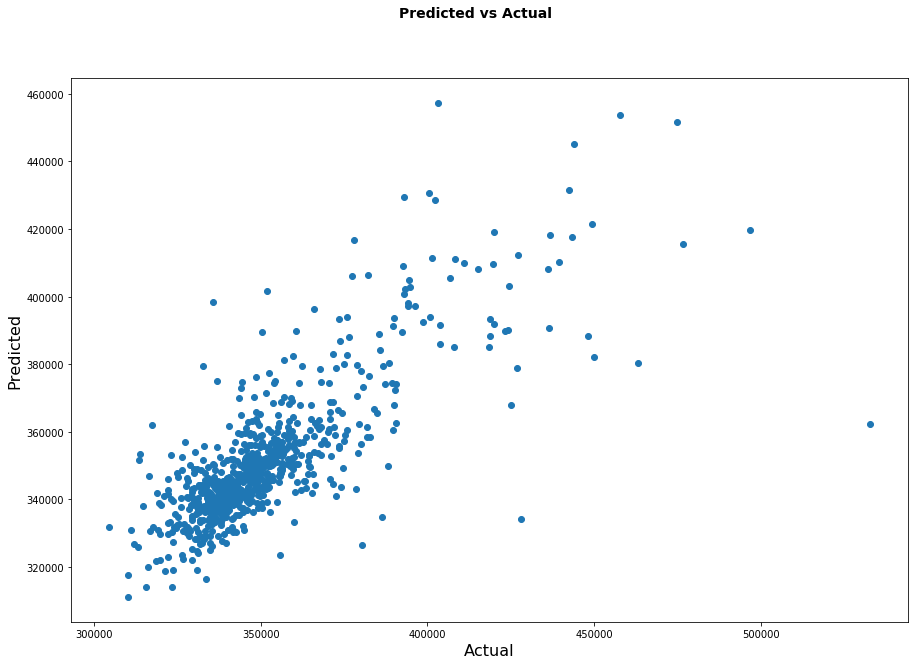

In [7]:
mod, fig, x, y_train, mse = create_model("Gelderland",False)
mod.summary()


# Normality Tests of Residuals
For the jarque-bera test we see that the test statistic is far from zero and the p-value is lower than .05, thus the null hypothesis of normally distributed residuals is rejected, same goes for the omni test.

In [8]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(mod.resid)
print(lzip(name,test))
name = ['Chi^2', 'Two-tail probability']
test = sms.omni_normtest(mod.resid)
print(lzip(name,test))

[('Jarque-Bera', 7834.652178626376), ('Chi^2 two-tail prob.', 0.0), ('Skew', 0.2840702893600857), ('Kurtosis', 13.897704344179225)]
[('Chi^2', 321.3386277157225), ('Two-tail probability', 1.6680289363570274e-70)]


# Heteroskedasticity tests
In both tests the null hypothesis of homoskedasticity is rejected.

In [9]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(mod.resid, mod.model.exog)
print(lzip(name,test))
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(mod.resid, mod.model.exog)
print(lzip(name,test))

[('Lagrange multiplier statistic', 179.78629055439862), ('p-value', 4.7197029331084047e-32), ('f-value', 16.768068207854547), ('f p-value', 3.94167787649621e-34)]
[('F statistic', 0.9444468054740159), ('p-value', 0.7869884103037772)]


# Linearity Plot

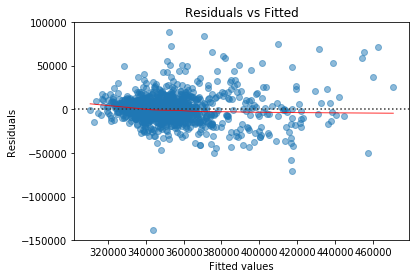

In [10]:
# model values
model_fitted_y = mod.fittedvalues
plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, list(itertools.chain.from_iterable(y_train)),lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

# Multicolinearity
Usually a factor greater than 5 is indicative of high collnearity.

In [11]:

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['Variables'] = x.columns

vif.round(1)

,VIF Factor,Variables
0,16019.9,const
1,1.5,jaarfractie
2,1.0,bevolking
3,1.6,summer-vac
4,1.2,tem>20
5,1.1,verd De Bilt
6,2.1,zaagtand
7,1.7,weekdag1
8,1.7,weekdag2
9,1.7,weekdag3


# QQ-plot

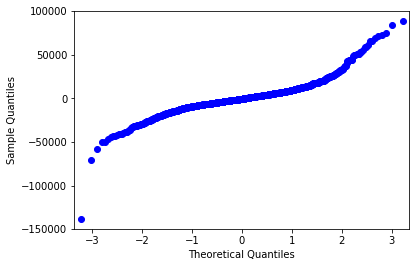

In [12]:
fig = sm.qqplot(mod.resid)
plt.show()

# Coefficients of Model

In [13]:
err_series = mod.params - mod.conf_int()[0]

coef_df = pd.DataFrame({'coef': mod.params.values[1:],
                        'err': err_series.values[1:],
                        'varname': err_series.index.values[1:]
                       })

coef_df

,coef,err,varname
0,3897.634902,3083.880667,jaarfractie
1,0.219600,0.043915,bevolking
2,-9248.069432,2907.187578,summer-vac
3,8538.491857,351.806935,tem>20
4,1247.373757,372.467216,verd De Bilt
5,31011.736871,4003.442102,zaagtand
6,-16874.760419,2696.187097,weekdag1
7,-4418.064081,2659.695939,weekdag2
8,-9123.023147,2648.206734,weekdag3
9,-3658.853825,2660.239261,weekdag4


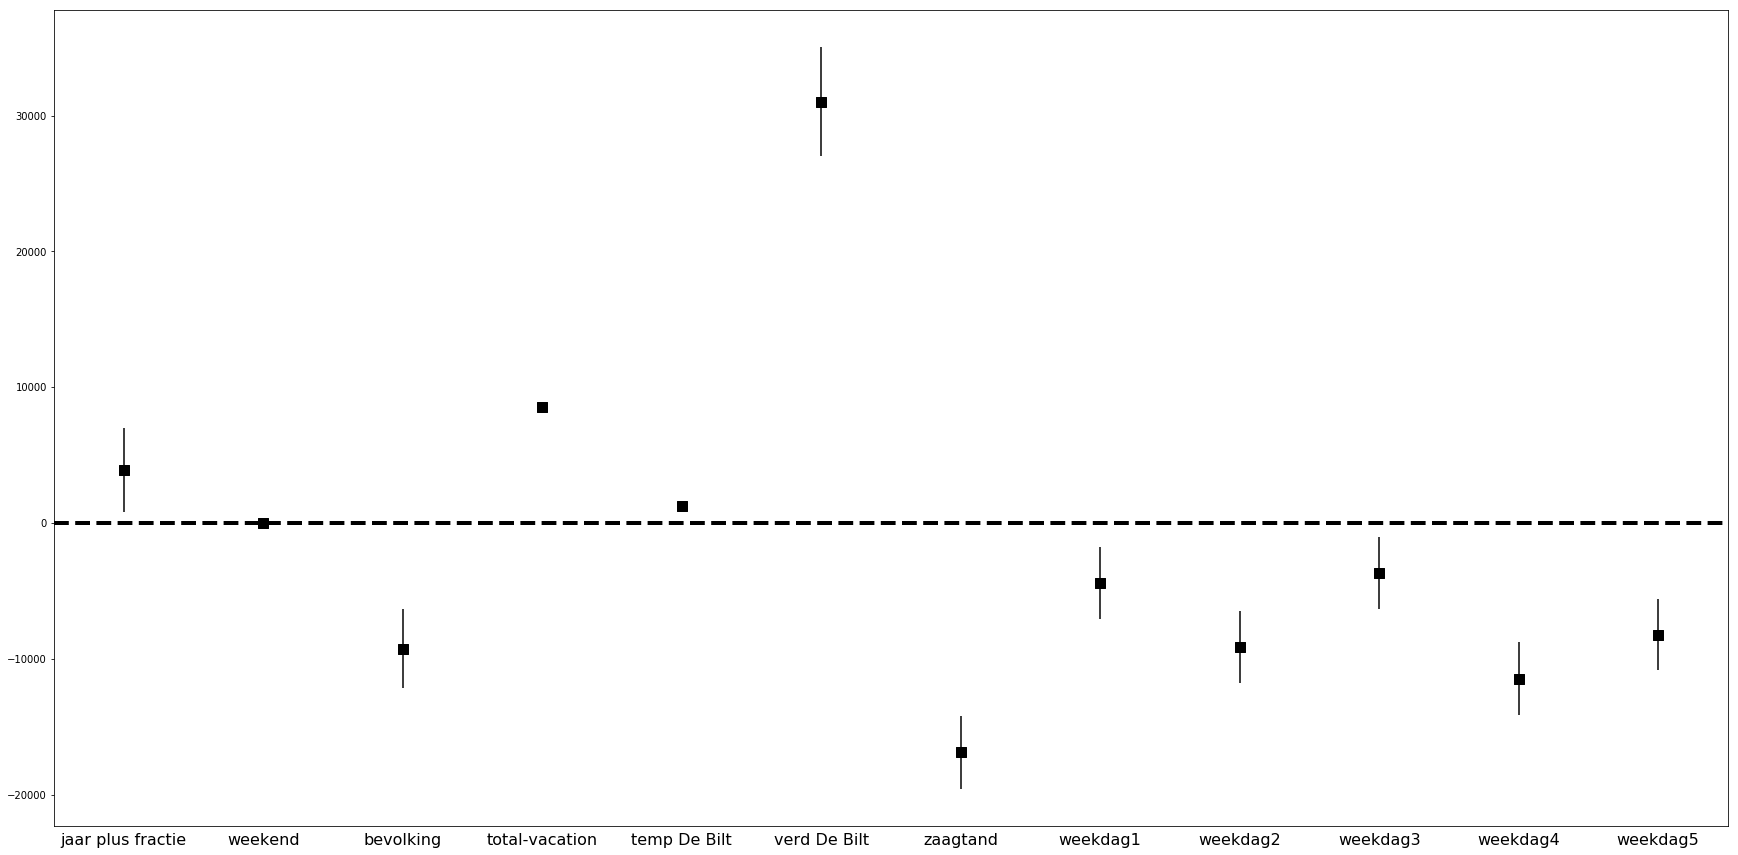

In [14]:
fig, ax = plt.subplots(figsize=(30, 15))
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(['jaar plus fractie', 'weekend', 'bevolking','total-vacation','temp De Bilt','verd De Bilt','zaagtand','weekdag1','weekdag2','weekdag3','weekdag4','weekdag5','weekdag6'], 
                       rotation=0, fontsize=16)